# PMR3508 - KNN for Dataset Adult

Author: João Henri Carrenho Rocha
NUSP: 11796378
HASH: PMR3508-2022-61

In this notebook, we will be studying [UCI Repository's Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). Also known as the "Census income" dataset, it contains features regarding age, education, occupation, and more. Our objective is to predict whether a person's income exceeds $50K/yr based on their census data.

Firstly, we will execute an exploratory data analysis to understand and clean the dataset that we will be working with. Then, we will try to predict our label "income" using the [_k_-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

# 1) Tooling

Under this section, we will add all libraries and additional functions used in the following analysis.

In [1]:
# ------------------------------------------------------------
# --------------- Dataset Manipulation -----------------------
# ------------------------------------------------------------

# Used to check if a column is numerical or categorical
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# Used to manipulate datasets
import pandas as pd

# ------------------------------------------------------------
# ---------------- Machine Learning --------------------------
# ------------------------------------------------------------

# Used to transform the 'income' label in 0s and 1s
from sklearn.preprocessing import LabelEncoder

# Used to transform categorical columns in new boolean columns
from sklearn.preprocessing import OneHotEncoder

# Used to scale numerical columns following normal distribution
from sklearn.preprocessing import StandardScaler

# Used to scale sparse numerical columns according to the
# quantile range
from sklearn.preprocessing import RobustScaler

# Used to create Pipelines to apply encoders and scalars
from sklearn.pipeline import Pipeline

# Used to apply the pipelines above
from sklearn.compose import ColumnTransformer

# Used to split dataset between sets of train and test
from sklearn.model_selection import train_test_split

# Used to train a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Used to perform cross-validations
from sklearn.model_selection import cross_val_score

# Used to plot the ROC curve
from sklearn.metrics import RocCurveDisplay

# Used to plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Used to check general metrics of the model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# ------------------------------------------------------------
# ---------------- Data Visualization ------------------------
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 2) Importing training and testing datasets

In [2]:
train_data = pd.read_csv("kaggle/input/adult-pmr3508/train_data.csv",
                         sep=r'\s*,\s*',
                         engine='python',
                         na_values="?")

test_data = pd.read_csv("kaggle/input/adult-pmr3508/test_data.csv",
                        sep=r'\s*,\s*',
                        engine='python',
                        na_values="?")
train_data.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


For this analysis, we will be working with 15 feature columns and 1 label column.

At first glance, it is important to notice there are several categorical fields. These will require some special attention in order to our KNN model work.

# 3) Exploratory Data Analysis

For this section, we will start visualizing and understanding the distribution of each column. Subsequently, we will investigate the correlation between different variables.

Finally, having all this information gathered, we will decide how to deal with null cells, which columns to normalize, and which should we drop and how to deal with null cells. Keep in mind that our final product should be a KNN model, so there is much to do regarding categorical variables.

## 3.1) Data Visualization

Let's divide our analysis in two segments: categorical and numerical variables:

In [3]:
numerical_columns = [i for i in train_data.columns if is_numeric_dtype(train_data.dtypes[i])]
categorical_columns = [i for i in train_data.columns if is_string_dtype(train_data.dtypes[i])]
numerical_columns.remove('Id')

### 3.1.1) Visualizing Numerical Variables

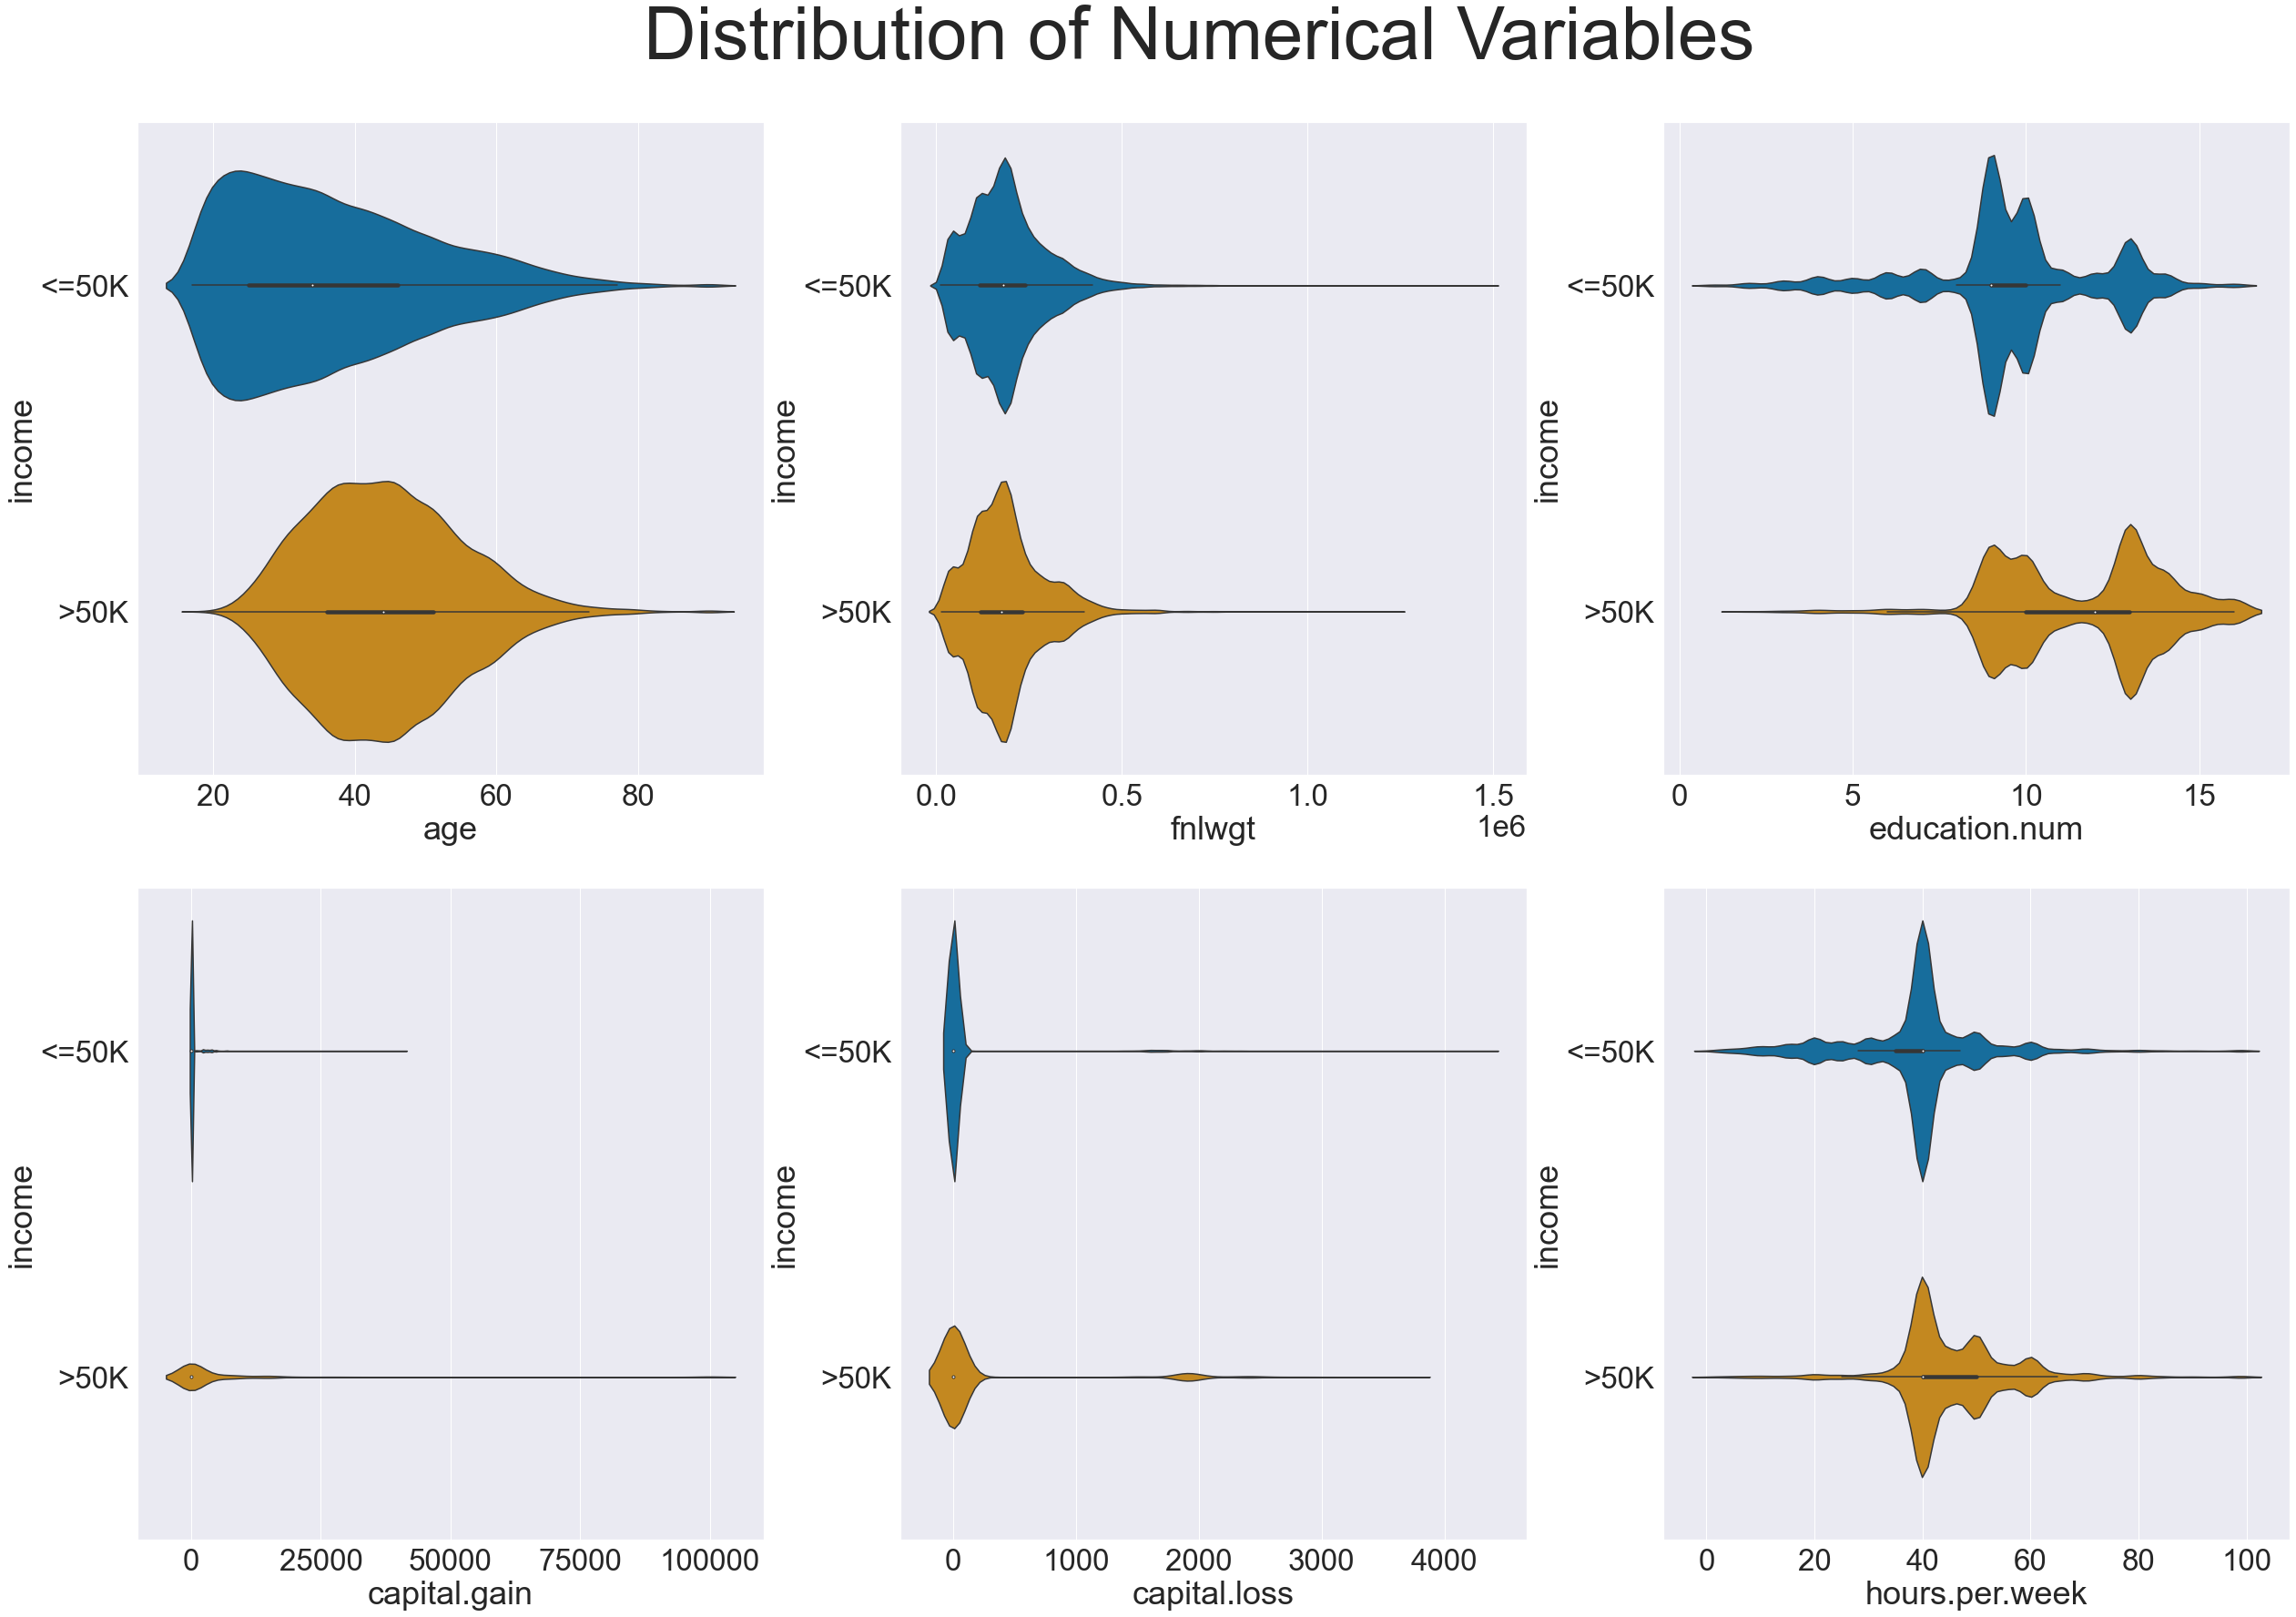

In [4]:
sns.set(font_scale = 3)
fig, axes = plt.subplots(2, 3, figsize=(35, 25), sharey=False)
fig.suptitle('Distribution of Numerical Variables', size = 80)
fig.tight_layout(h_pad = 2, w_pad = 2)

for i, numerical_col in enumerate(numerical_columns):
    ax = sns.violinplot(data = train_data, x = numerical_col, y = 'income', ax = axes[i//3, i%3], palette = 'colorblind')

plt.show()

From the distributions above:
- **age**: As expected, people in their 30s, 40s, and 50s are expected to earn more.
- **fnlwgt**: Both distributions follow the same pattern and are way too similar. Later, we should probably disconsider it.
- **education.num**: The plot suggests that the salary increases as the education increases.

As defined in [Topic No. 409 Capital Gains and Losses](https://www.irs.gov/taxtopics/tc409) by USA's Internal Revenue Service:
> Almost everything you own and use for personal or investment purposes is a capital asset. Examples include a home, personal-use items like household furnishings, and stocks or bonds held as investments. When you sell a capital asset, the difference between the adjusted basis in the asset and the amount you realized from the sale is a capital gain or a capital loss.


- **capital.gain** and **capital.loss**: Intuitively, people with higher capital gains are more likely to make more than 50k yearly. However, it does look like this distribution is skewed as there are very few people doing hundreds of thousands of dollars only by trading assets. On top of that, the vast majority of people are concentrated around 0.
- **hours.per.week**: For both labels, the majority of people lies in the full-time range (40 hours per week). However, it does look like part-time workers are much more likely to earn less than 50k yearly. Also, people that do overtime and workaholics (> 40 hours per week) are more likely to lie in the above 50k classification.

### 3.1.2) Visualizing Categorical Variables

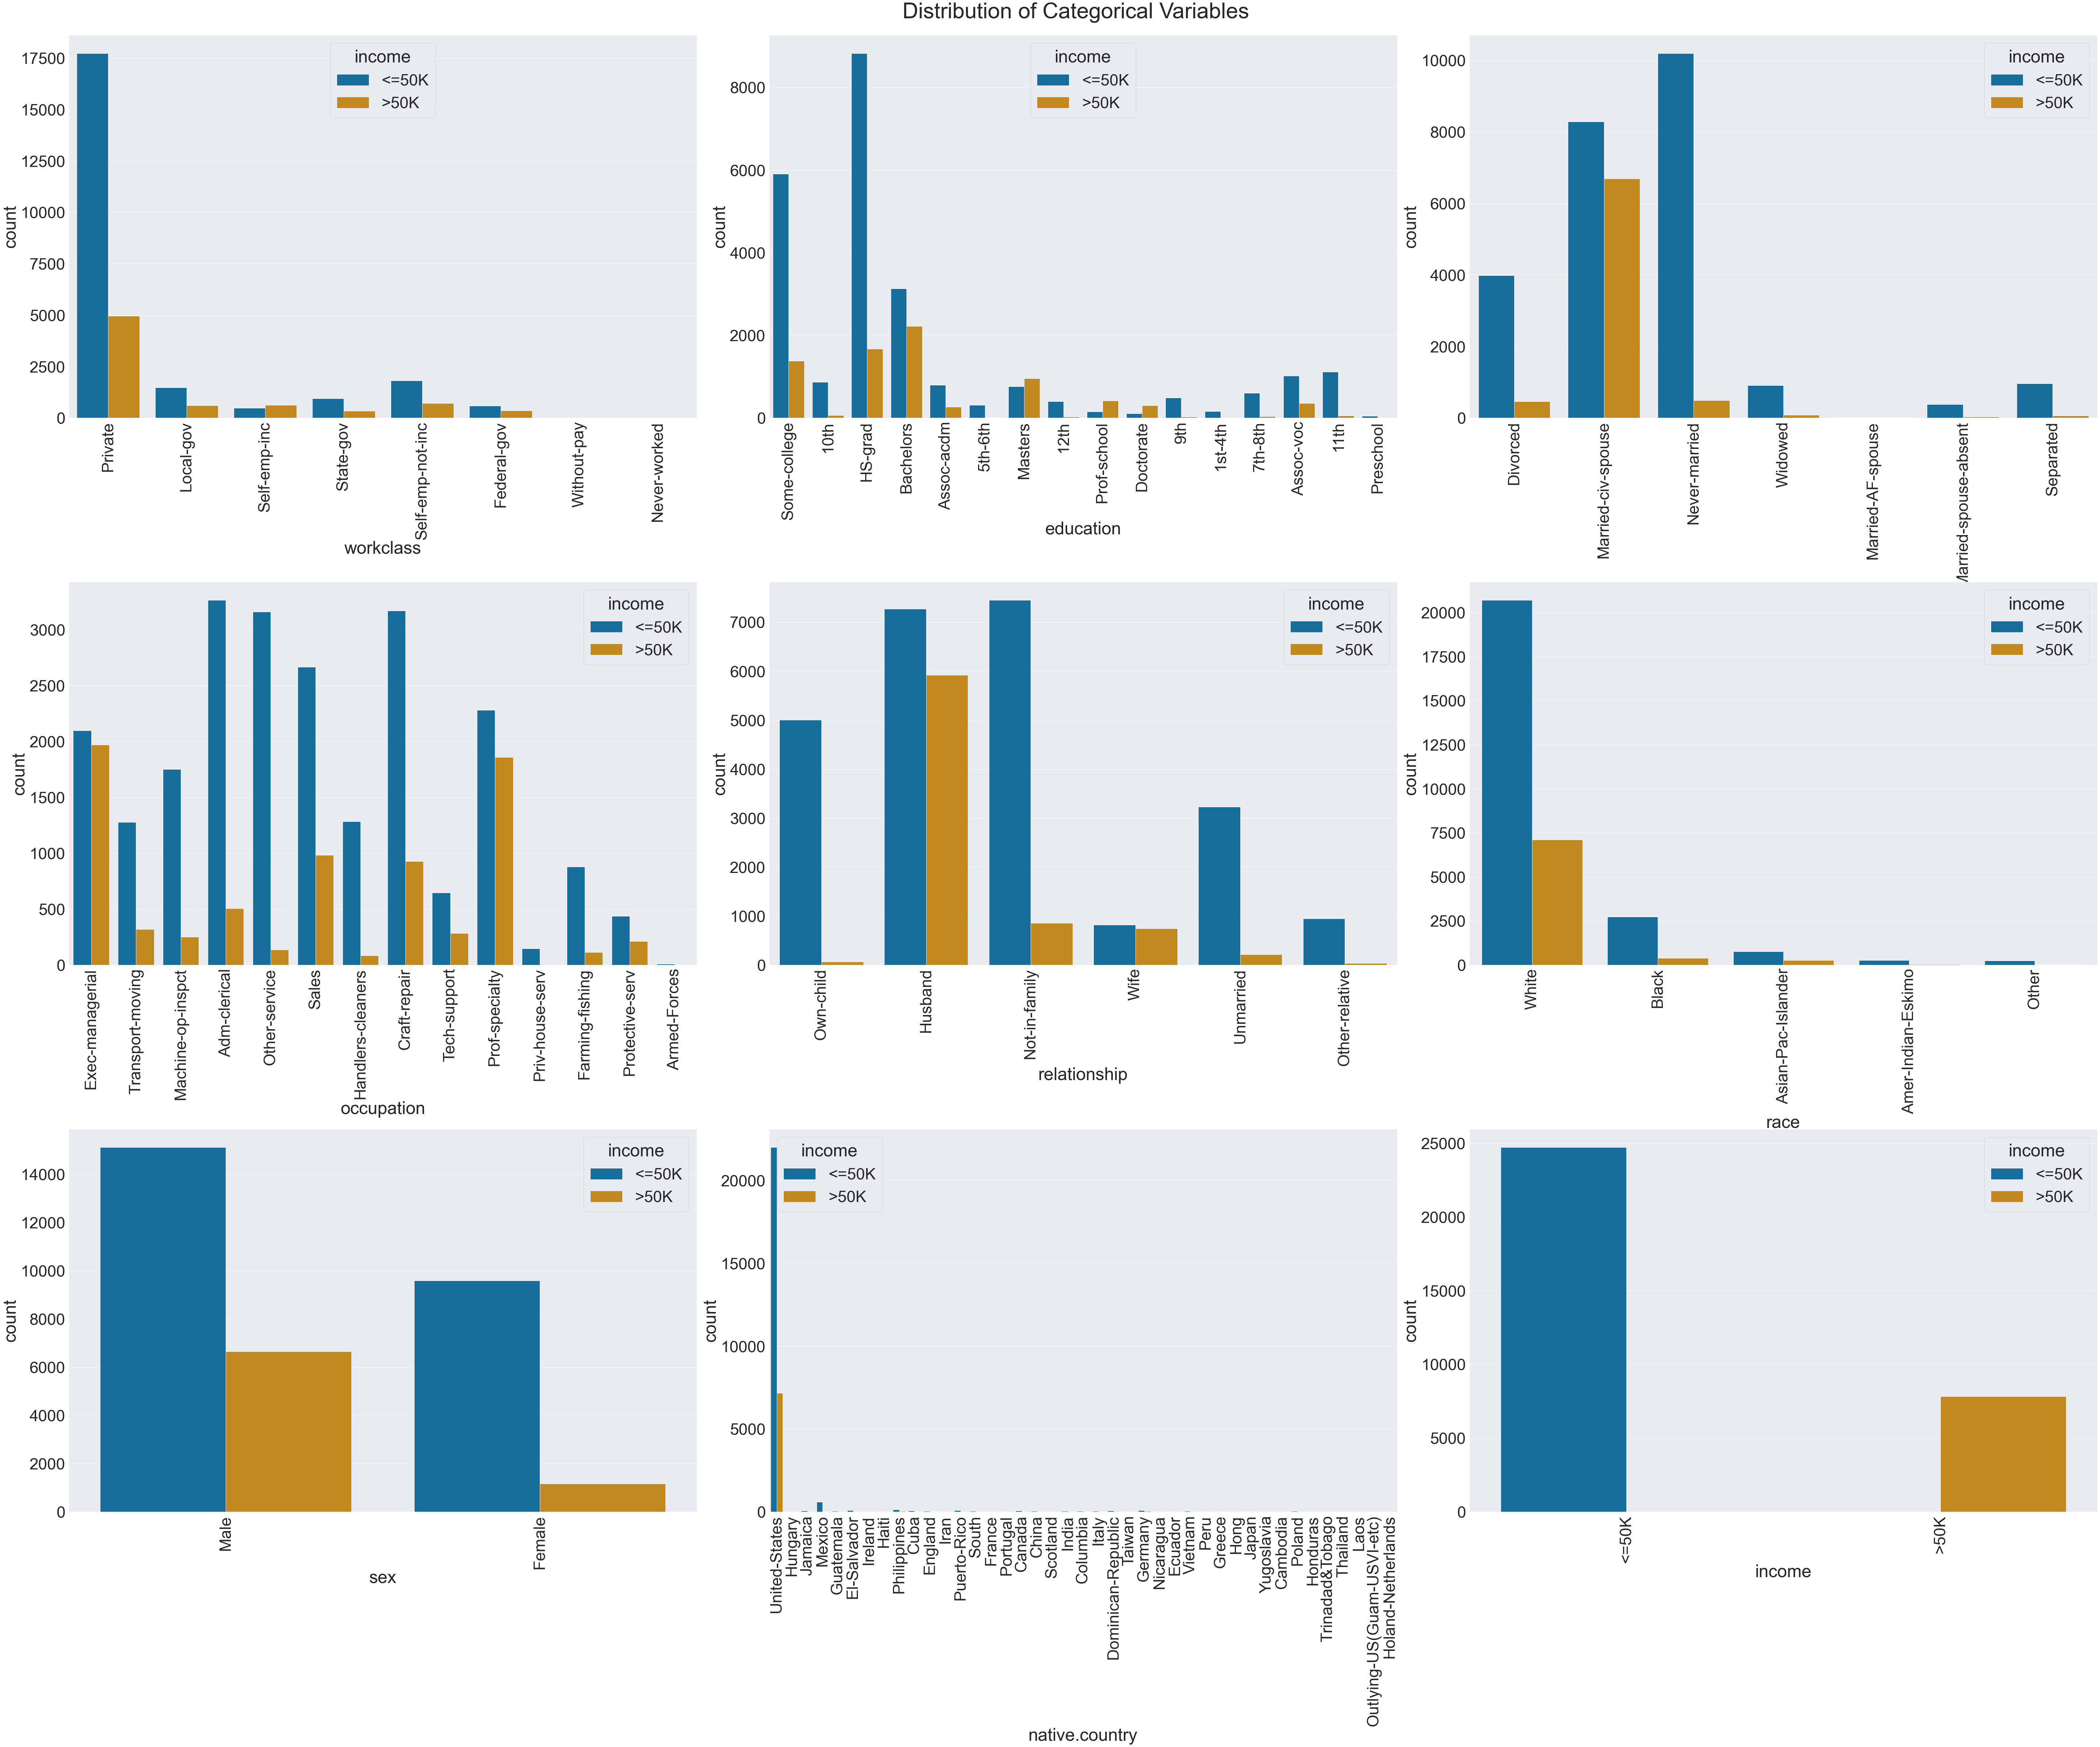

In [5]:
sns.set(font_scale = 4)
fig, axes = plt.subplots(3, 3, figsize=(80,60), sharey=False)
fig.suptitle('Distribution of Categorical Variables', size = 60)
fig.tight_layout(h_pad = 8, w_pad = 2)

for i, categorical_col in enumerate(categorical_columns):
    ax = sns.countplot(data = train_data, x = categorical_col, hue = 'income', ax = axes[i//3, i%3], palette = 'colorblind')

    # Here we rotate the X labels to fit under the graph
    ax.tick_params(axis='x', labelrotation = 90)

plt.show()

- **workclass**: data seems a little biased as most respondents are from the private sector. However, the relation between class and income seems clear.
- **education**: it looks like this column represents the same information given in the **education.num** field above. This field is very important as we see that starting from Bachelor's, people with higher education tend to earn more than 50k. Maybe it makes sense to order this field so that it works with KNN. Otherwise, we would have to use One Hot Encoding, highly increasing the problem's dimensionality.
- **marital.status**: the ones earning more are concentrated in the married to civilian spouse category.
- **occupation**: this is probably of the most important piece of information available in the dataset.
- **relationship**: again, we notice that husbands and wives are more likely to earn better. However, this column severely overlaps with __marital.status__ and is basically a merge between it and **sex**. We should drop this column further on.
- **race** unfortunately, the race is impactful when deciding the income of someone. We see that white people are the majority earning well. Aside from this interpretation, we should probably merge "Amer-Indian-Eskimo" with the "Other" category as there is not enough data presented there.
- **sex**: once more, we see a salary inequality between males and females.
- **country**: aside from the US, there is not much data available regarding other countries here. We should probably remove this column from our model.

# 3.2) Data Cleaning

Having understood the distribution of the presented data and checked what we have to deal with, the next step is to deal with null variables and do some data preparation in order to fit the model later on.

## 3.2.1) Checking Nulls

In the next section we will check how many nulls there are, in which columns they appear and decide how to deal with them. The first step, presented in the table below, is to check the percentages of null values in columns that have them.

In [6]:
columns_with_nulls = train_data.columns[train_data.isnull().any()]

total_rows = train_data.shape[0]
train_data[columns_with_nulls].isnull().sum() * 100 / total_rows

workclass         5.638821
occupation        5.660319
native.country    1.790541
dtype: float64

We don't need to worry about **native.country** as we will drop it soon. As checked in the list below, most entries have less than 100 respondents. Our model could become too biased towards these nationalities without a justifiable amount of interviewees.

In [7]:
countries = []
raw_quantities = []
percentages = []
for country, quantity in train_data['native.country'].value_counts(sort = True).iteritems():
    countries.append(country)
    raw_quantities.append(quantity)
    percentages.append(round(quantity/total_rows * 100, 3))

df_countries = pd.DataFrame(list(zip(countries, raw_quantities, percentages)), columns = ['country', 'respondents', 'percentage'])
df_countries

,country,respondents,percentage
0,United-States,29169,89.585
1,Mexico,643,1.975
2,Philippines,198,0.608
3,Germany,137,0.421
4,Canada,121,0.372
5,Puerto-Rico,114,0.350
6,El-Salvador,106,0.326
7,India,100,0.307
8,Cuba,95,0.292
9,England,90,0.276


Now, let's study the distribution of income for the workclass and occupation values. Maybe these nulls follow a pattern and we don't really need to exclude these rows.

<AxesSubplot:xlabel='occupation', ylabel='count'>

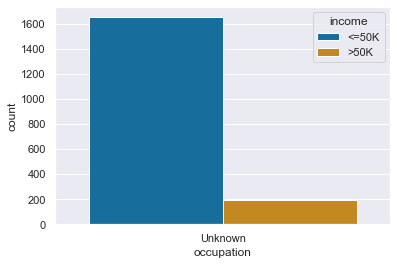

In [8]:
null_occupation = train_data[train_data['occupation'].isna()].copy(deep = True)
null_occupation['occupation'] = 'Unknown'

sns.set()
sns.countplot(data=null_occupation, x = 'occupation', hue = 'income', palette='colorblind')

It seems that people with unknown occupations are more likely to earn less than $50k yearly. This way, in the data preparation stage we will substitute these values with tha "Unknown" label and keep them.

<AxesSubplot:xlabel='workclass', ylabel='count'>

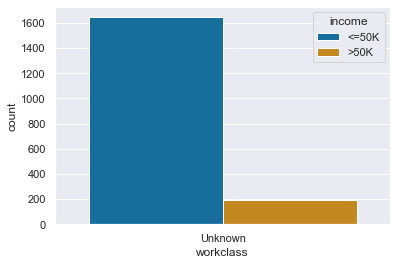

In [9]:
null_workclass = train_data[train_data['workclass'].isna()].copy(deep = True)
null_workclass['workclass'] = 'Unknown'

sns.countplot(data=null_workclass, x = 'workclass', hue = 'income', palette='colorblind')

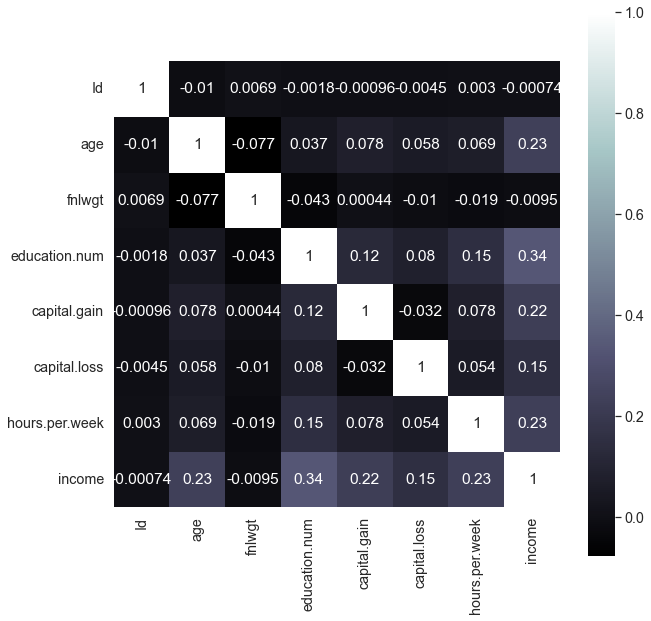

In [10]:
correlations = train_data.copy()

# Transform 'income' column in 0s and 1s such that we can check how it correlates
# to other numerical variables
le = LabelEncoder()
correlations['income'] = le.fit_transform(correlations['income'])

plt.figure(figsize=(10,10))
sns.set(font_scale=1.3)

sns.heatmap(correlations.corr(), square = True, annot=True, cmap='bone')
plt.show()

Notice that basically the same conclusion above is valid here, numbers and ratios are also very similar. Thus, we can avoid discarding almost 5% of our available entries.

## 3.2.2) Correlations

One last thing to understand is how the numerical variables correlate with each other.

As noticed previously, the column **fnlwgt** barely correlates to the income label. We will be dropping it.

# 3.3) Data preparation

This is the stage where we finally do modifications to our dataset. Whether we will rearrange data, modify values and even drop columns that don't make sense.

## 3.3.1) Dropping Columns
As discussed before, there are two columns that we will be removing:
- **Id**: this country has no correlation with someone's income. It is a random generated number used to identify an entry/person.
- **native.country**: most countries have too few respondents. Thus, it is a better idea to ignore it.
- **fnlwgt**: it represents the "final weight", i.e., this is the number of people the census believes the entry represents. As repeated entries shouldn't affect the final result, we will drop it.
- **relationship**: it works like a merge of **marital.status** and **sex**. Consequently, can be ignored.
- **education***: it is a categorical version of **education.num**.

In [11]:
train_data = train_data.drop(columns = ['Id', 'native.country', 'fnlwgt', 'relationship', 'education'])
test_data = test_data.drop(columns = ['Id', 'native.country', 'fnlwgt', 'relationship', 'education'])

train_data.head()

,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,income
0,34,Private,10,Divorced,Exec-managerial,White,Male,0,0,44,<=50K
1,58,Local-gov,6,Married-civ-spouse,Transport-moving,White,Male,0,0,40,<=50K
2,25,Private,10,Never-married,Machine-op-inspct,White,Male,0,0,42,<=50K
3,24,Private,10,Divorced,Adm-clerical,White,Female,0,0,40,<=50K
4,57,Self-emp-inc,9,Married-civ-spouse,Transport-moving,White,Male,5178,0,60,>50K


## 3.3.2) Dealing With Nulls
As we decided to keep the unknown occupations and workclasses, let's replace the nulls with a new "Unknown" category.

In [12]:
train_data['occupation'].fillna('Unknown', inplace = True)
train_data['workclass'].fillna('Unknown', inplace  = True)

test_data['occupation'].fillna('Unknown', inplace = True)
test_data['workclass'].fillna('Unknown', inplace  = True)

train_data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
Unknown              1836
State-gov            1297
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

# 4) KNN Model

Our first step will consist in the division of our set between features and labels:

In [13]:
Y_train = train_data.pop("income")
X_train = train_data

X_kaggle_test = test_data

X_train.head()

,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week
0,34,Private,10,Divorced,Exec-managerial,White,Male,0,0,44
1,58,Local-gov,6,Married-civ-spouse,Transport-moving,White,Male,0,0,40
2,25,Private,10,Never-married,Machine-op-inspct,White,Male,0,0,42
3,24,Private,10,Divorced,Adm-clerical,White,Female,0,0,40
4,57,Self-emp-inc,9,Married-civ-spouse,Transport-moving,White,Male,5178,0,60


Then, let's divide our features in three categories:
- Numerical
- Sparse
- Categorical

This division is necessary in order to apply standardization techniques to our values. While categorical classes require a One Hot Encoding approach, numerical values may require a Standardization. Also, we observed previously that there are two columns (**capital.gain** and **capital.loss**) that don't follow a Normal distribution and also contain a significant amount of outliers. Therefore, they will receive a different treatment.

In [14]:
categorical_columns = ['workclass', 'marital.status', 'occupation', 'race', 'sex']
numerical_columns = ['age', 'education.num', 'hours.per.week']
sparse_columns = ['capital.gain', 'capital.loss']

Thus, we create the respective pipelines for each type of data. As mentioned, we will use a One Hot Encoding technique for categorical fields.

For numerical values, we use the StandardScaler: it transforms the data in such a manner that it gets mean as 0 and standard deviation as 1.
In short, it standardizes the data, i.e., it arranges the data in a standard normal distribution.

For the sparse values, we use a RobustScaler: by using it, we can remove the outliers. It scales features using statistics that are robust to outliers. This method removes the median and scales the data in the range between 1st quartile and 3rd quartile. i.e., in between 25th quantile and 75th quantile range. This range is also called an Interquartile range.

In [15]:
categorical_pipeline = Pipeline(steps = [('onehot', OneHotEncoder(drop='if_binary'))])
numerical_pipeline = Pipeline(steps = [('scaler', StandardScaler())])
sparse_pipeline = Pipeline(steps = [('scaler', RobustScaler())])

The following cell creates the transformer that will effectively apply the pipelines to their respective columns.

In [16]:
preprocessor = ColumnTransformer(transformers = [
    ('categorical', categorical_pipeline, categorical_columns),
    ('numerical', numerical_pipeline, numerical_columns),
    ('sparse', sparse_pipeline, sparse_columns),
])

Finally, we call apply the transformer to our dataset:

In [17]:
X_train = preprocessor.fit_transform(X_train)
X_kaggle_test = preprocessor.fit_transform(X_kaggle_test)

In the following cell, we will split the train data between train and test. We are doing so in a manner that 80% of the entries are reserved for training and 20% for testing. Also, we are using a seed 61 (the author's hash number) so it is reproducible for the teaching assistant, professor or other colleagues studying this notebook.

Notice that this __X_train__ variable defined above is not the data from Kaggle's test sample. It is a part of the training data spared for us to check the metrics in the following section. We can't really use the test data here because it does not have the income column, thus, we can't compare our predictions to their real values.

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state = 61)

Now, it makes sense to check which value of the hyperparameter **k** optimizes the accuracy, i.e., minimizes the error:

In [19]:
k = [5, 10, 15, 20, 25, 30]
k_accuracy = {}

for current_k in k:
    # We will perform cross-validation with 20 folds
    score = cross_val_score(KNeighborsClassifier(n_neighbors = current_k), X_train, Y_train, cv = 20, scoring = "accuracy").mean()
    k_accuracy[current_k] = score

In the dataframe below, we can check the accuracies found for each value of the hyperparameter **k**.

In [20]:
pd.DataFrame(k_accuracy.items(), columns = ['k', 'accuracy'])

,k,accuracy
0,5,0.857378
1,10,0.864712
2,15,0.864405
3,20,0.866785
4,25,0.866324
5,30,0.865748


In [21]:
optimal_k = max(k_accuracy, key = k_accuracy.get)

print('So, we were able to reach ' + str(k_accuracy[optimal_k])+ ' accuracy with K = ' + str(optimal_k) + '! Interestingly enough, for the studied values, the value of K itself does not seem to make much difference!')

So, we were able to reach 0.8667847623291636 accuracy with K = 20! Interestingly enough, for the studied values, the value of K itself does not seem to make much difference!


Redefining our best final model:

In [22]:
knn_classifier = KNeighborsClassifier(n_neighbors = optimal_k)
knn_classifier.fit(X_train, Y_train)

Y_predicted = knn_classifier.predict(X_test)

# 5) Model Evaluation

Finally, it is important to measure the error rates, accuracy and precision of our model. Firstly, let's check the ROC curve of our model:

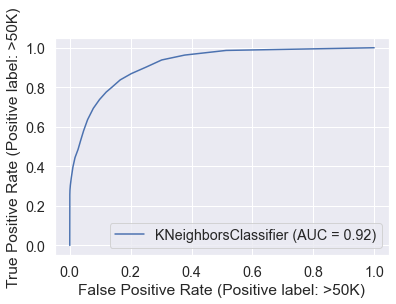

In [23]:
RocCurveDisplay.from_estimator(knn_classifier, X_test, Y_test)

It means that in 92% of the cases, our model is able to distinguish people that make more than $50k yearly from those that don't. Still, it makes sense to check the Confusion Matrix to understand where is the model's weak spot:

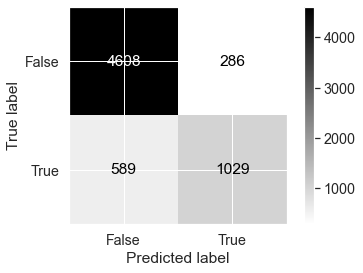

In [24]:
confusion_matrix = confusion_matrix(Y_test, Y_predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap='binary')
plt.show()

From the confusion matrix above, it is possible to conclude that our model's weak spot

In [25]:
print('Accuracy:  ' + str(accuracy_score(Y_test, Y_predicted)))
print('Recall:    ' + str(recall_score(Y_test, Y_predicted, pos_label='>50K')))
print('Precision: ' + str(precision_score(Y_test, Y_predicted, pos_label='>50K')))
print('F1 Score:  ' + str(f1_score(Y_test, Y_predicted, pos_label='>50K')))

Accuracy:  0.8656326781326781
Recall:    0.6359703337453646
Precision: 0.782509505703422
F1 Score:  0.7016706443914081


From the tests above, we can see that the model's recall has a quite low score. This means that the model is fairly biased to predicting that someone's income does not meet $50k yearly when it in fact does.

# 6) Submission

For the last step, we must submit a csv file containing our predictions for the available test dataset. We will predict values using the Kaggle's test dataset and create a Dataframe including 'Id' and 'income' columns.

In [29]:
predictions = knn_classifier.predict(X_kaggle_test)

submission_df = pd.DataFrame(list(zip(test_data.index, predictions)), columns = ['Id', 'income'])
submission_df.head()

,Id,income
0,0,<=50K
1,1,>50K
2,2,<=50K
3,3,<=50K
4,4,>50K


Finally, let's generate a csv from the submission dataframe above:

In [30]:
submission_df.to_csv('submission.csv', index = False)